In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import re
import random
import operator #to sort elements in a list of tuples
import itertools
import math
import numpy as np
import Cascade_generation_functions as C_gen
import os

In [16]:
save_path_cascade = './Cascade_files/'

In [2]:
def Create_ground_truth_from_file(file):
    f = open(file,"r")
    G = nx.DiGraph()
    for nodes in f:
        if not nodes.strip(): ## Stop at the first blank line
            print("stop")
            break
        node = re.split(',|\n',nodes) # the format of the input file is <id>,<name>  
        vertex = node[0]
        names = node[1]
        G.add_node(int(vertex),name = names)
    for edges in f :
        edge = re.split(',|\n',edges)
        vertex_i = edge[0] # initial vertex of the directed edge
        vertex_f = edge[1] # final vertex of the edge
        G.add_edge(int(vertex_i),int(vertex_f),number_of_cascade_edge_is_in =0)
    return G

def Generate_DAG_and_Trees_from_cascade_file(file):
    f = open(file,"r")
    G = nx.DiGraph()
    cascade_list = []
    DAG_Tree_c_dic = {}

    #Reades the file and set up the nodes as well as the format for the cascades
    for nodes in f:
        if not nodes.strip(): ## Stop at the first blank line
            print("All nodes were read")
            break
        node = re.split(',|\n',nodes) # the format of the input file is <id>,<name>  
        vertex = node[0]
        names = node[1]
        G.add_node(int(vertex),name = names)
    for cascades in f:
        cascades = cascades.split("\n")
        cascade_list.append(cascades[:-1])# small adjustment to make a standard format (i.e remove \n at the end)

    #Generates the DAG and Trees for each cascade and stores it into a dic. (DAG,Tree)
    for index,c in enumerate(cascade_list) :
        DAG_c = Create_weighted_DAG_from_cascade(c[0],G)
        Tree_c = Find_max_weight_spanning_tree_in_DAG(DAG_c)
        DAG_Tree_c_dic[index] = (DAG_c,Tree_c)
    return (G,DAG_Tree_c_dic)

def Save_graph_to_file(G,file_name):
    f = open(file_name,"w")
    for nodes in G.nodes() :
        f.write(str(nodes)+","+str(nodes)+"\n")
    f.write("\n")
    for edges in G.edges():
        v1,v2 = edges
        f.write(str(v1)+","+str(v2)+"\n")
    f.close()

# This does not make sense for me. But for now I implement the same function they used in their c++ code
def Get_edge_weight(alpha,time1,time2):
    delta = time2-time1
    if delta<=0:
        weight = 0
        return weight
    weight = alpha*math.exp(-alpha*delta)
    return weight
        
def Create_weighted_DAG_from_cascade(cascade,weighted_network):
    DAG = nx.DiGraph()
    cascade = cascade.split(";")
    data_cascade = []
    for elements in cascade:
        elements = elements.split(',')
        data_cascade.append([int(elements[0]),float(elements[1])])
        DAG.add_node(int(elements[0]),time = float(elements[1]))
    for couple1 in data_cascade :
        vertex1,time1 = couple1
        for couple2 in data_cascade :
            vertex2,time2 = couple2
            if time1<time2 : #The propagation can only move forward
                if (vertex1,vertex2) in weighted_network.edges :
                    weights = weighted_network.edges[vertex1,vertex2]['weight'] #Weight of an already "optimal" edge
                else :
                    weights = 0 #Should be updated with the weights of the epsilon-edge
                DAG.add_edge(vertex1,vertex2,weight = weights)
    return DAG

def Find_max_weight_spanning_tree_in_DAG(DAG):
    Spanning_tree = nx.DiGraph()
    Spanning_tree.add_nodes_from(DAG.nodes)
    for vertex in DAG.nodes:
        if DAG.in_degree[vertex]!=0 :
            max_weight = 0
            for parents in list(DAG.predecessors(vertex)):
                weight = DAG.edges[parents,vertex]['weight']
                if weight>=max_weight:
                    max_weight = weight
                    edge_to_add = (parents,vertex)
            Spanning_tree.add_edge(edge_to_add[0],edge_to_add[1], weight = max_weight)
    return Spanning_tree

def Compute_marginal_gain(G,DAG_Tree_c_dic):
    poss_edge = itertools.combinations(G.nodes,2) #Compute all possible edges
    dic_of_gains = {}
    dic_of_cascades_per_edge = {}
    for edge in list(poss_edge) :
        if edge not in G.edges : #Considers only the edges that where not already added to G
            marginal_improve = 0
            list_of_cascade = []
            for i in range(0,len(DAG_Tree_c_dic)):
                if edge in DAG_Tree_c_dic[i][0].edges : #Consider only the cascades in which the edge is actually present
                    u,v = edge
                    time_u = DAG_Tree_c_dic[i][0].node[u]["time"]
                    time_v = DAG_Tree_c_dic[i][0].node[v]["time"]
                    parent_v = list(DAG_Tree_c_dic[i][1].predecessors(v))[0]
                    current_weight = DAG_Tree_c_dic[i][1].edges[(parent_v,v)]["weight"]
                    weight_uv = Get_edge_weight(1.0,time_u,time_v)
                    if weight_uv >= current_weight :
                        marginal_improve = marginal_improve + weight_uv-current_weight
                        list_of_cascade.append(i)
            dic_of_gains[edge] = marginal_improve
            dic_of_cascades_per_edge[edge] = list_of_cascade
    return dic_of_gains,dic_of_cascades_per_edge

def Find_best_edge(dic_of_gains,G) :
    maxi = 0
    for key in dic_of_gains.keys() :
        current = dic_of_gains[key]
        if current>maxi :
            maxi = current
            max_key = key      
    G.add_edge(max_key[0],max_key[1])
    return G,max_key
    
def Update_trees(best_edge,dic_of_cascades_per_edge,DAG_Tree_c_dic,alpha):
    for i in dic_of_cascades_per_edge[best_edge] :
        u,v = best_edge
        Tree = DAG_Tree_c_dic[i][1]
        DAG = DAG_Tree_c_dic[i][0]
        parent_v = list(Tree.predecessors(v))[0]
        Tree.remove_edge(parent_v,v)
        t_u = DAG.nodes[u]["time"]
        t_v = DAG.nodes[v]["time"]
        best_edge_weight = Get_edge_weight(alpha,t_u,t_v) 
        Tree.add_edge(u,v,weight = best_edge_weight)
        DAG_Tree_c_dic[i] = (DAG,Tree)
    return DAG_Tree_c_dic


stop


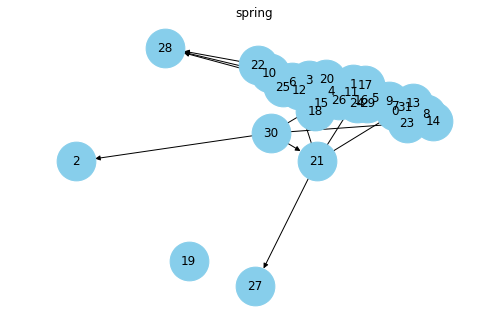

In [3]:
G_true = Create_ground_truth_from_file("example-network.txt")
nx.draw(G_true, with_labels=True, node_size=1500, node_color="skyblue", pos=nx.spring_layout(G_true))
plt.title("spring")
plt.show()
nx.write_gexf(G_true,"Test.gexf") # Save the graph in a file that is going to be used in the Gephi software (for visualization)


In [ ]:
alpha = 1.0
G,DAG_Tree_c_dic = Generate_DAG_and_Trees_from_cascade_file("example-cascades.txt")
while G.number_of_edges()<60 :
    dic_of_gains,dic_of_cascades_per_edge = Compute_marginal_gain(G,DAG_Tree_c_dic)
    G,best_edge = Find_best_edge(dic_of_gains,G)
    DAG_Tree_c_dic = Update_trees(best_edge,dic_of_cascades_per_edge,DAG_Tree_c_dic,alpha)

In [ ]:
'''
Less useful functions for the moment

'''

# dic_test = C_gen.Generate_all_cascades(G_true,95,0.5,1,100,0)
# file_name = "test_cascade_plop2.txt"
# completeName = os.path.join(save_path_cascade, file_name)
# C_gen.Save_cascade_to_file(completeName,dic_test,G_true)

# def Generate_random_graph(nb_vertex,nb_edges):
#     G = nx.DiGraph()
#     for i in range(0,nb_vertex):
#         G.add_node(i,name = str(i))
#     while len(G.edges)<nb_edges :
#         v1 = int(random.choice(G.nodes)['name'])
#         v2 = int(random.choice(G.nodes)['name'])
#         while (v1,v2) in G.edges or v1==v2:
#             v2 = int(random.choice(G.nodes)['name'])
#         G.add_edge(v1,v2)
#     return G

# def Init_K_bar(number_of_nodes):
#     G = nx.complete_graph(number_of_nodes)
#     return G